In [1]:
import cmocean
import numpy as np
import xarray as xr
from os import path
from scipy import optimize
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from thermal.plotting import make_colorbar
from thermal.derived_fields import calc_mean_enthalpy

plt.rcParams['text.usetex'] = True

Equilibrium timescales: 
$$
s(t) = 
\begin{cases}
t      & {\rm if} \;\; \left| \hat{f}(t) - \hat{f}(t_0) \right| < 0.01\\
\infty & {\rm if} \;\; \left| \hat{f}(t) - \hat{f}(t_0) \right| \geq 0.01\\
\end{cases}
$$
$$
t_{\rm eq}\left( \hat{f}(t) \right) = {\rm  argmin} \left( 
\begin{cases}
t      & {\rm if} \;\; \frac{{\rm d}}{{\rm d} t}s(t) = \Delta t\\
\infty & {\rm if} \;\; \frac{{\rm d}}{{\rm d} t}s(t) \neq \Delta t\\
\end{cases}
% \frac{{\rm d}}{{\rm d} t}s(t)
  \right)
$$

In [2]:
src = xr.open_zarr('../result/crmpt12/surge2steady_timeseries.zarr/')
src = src.rolling(t=10, min_periods=1).mean('t').compute()
src = src.sortby('beta', ascending=False)

def normalize(src):
    """Recale min and max values to [0,1] respectively
    """
    return (src-src.min()) / (src.max()-src.min())

def find_equilibrium_timescale(da, threshold=0.025):
    """
    """
    # starting time 
    t_0 = da.t.isel(t=0)
    
    # final value of the timeseries, which we seek to threshold 
    x_f = da.isel(t=-1)
    
    # flip the time axis to it's decending, (i.e. work from S.S. backwards)
    da = da.sortby('t', ascending=False)
    
    # mask of nans where convergence threshold is not met
    mask = np.abs(da-x_f).where(lambda x: x < threshold)
    
    # timesteps where convergence threshold is met
    t_mask = xr.where(~mask.isnull(), mask.t, np.nan)
    
    # take the difference along the valid timesteps
    # round to 6 decimal palces prevent roundoff errros
    z = np.round(t_mask.diff('t'), 6)
    
    # find the ~first~ timestep (of the decedning time axis) where the convergence 
    # threshold is not met
    t_eq = z.where(z!=-0.1, drop=True).isel(t=0).t
    
    #return equilibrium time, relative to the start of the timeseries
    return t_eq - t_0

In [3]:
slices = [slice(0.1,3999, 1), slice(4000,7999, 1)]


def compute_timescales(var, threshold, slices=[slice(0.1,3999, 1), slice(4000,7999, 1)]): 
    
    cycles = []
    for i, slice_ in enumerate(slices):
        # use one common scale to normalize all the beta values for a given cycle
        da = normalize(src[var].sel(t=slice_))
        # find the equilibirum time
        eq_t = da.groupby('beta').map(find_equilibrium_timescale, threshold=threshold)
        # rename t axis to t_eq
        eq_t = eq_t.expand_dims('cycle').assign_coords({'cycle': ('cycle', [i])})
        # rename varibale to the diagnosticc variable 
        eq_t.name = var

        cycles.append(eq_t)

    ds = xr.concat(cycles, 'cycle')
    
    # make sure the beta values are acending 
    ds = ds.sortby('beta', ascending=False)
    
    return ds

In [4]:
V_prime   = compute_timescales('relative_volume',   0.01)
frac_temp = compute_timescales('percent_temperate', 0.01)
mean_enth = compute_timescales('mean_enthalpy',     0.01)

In [5]:
(src.mean_surge_vel_m  / src.mean_quies_vel_m)

<xarray.DataArray (beta: 9)>
array([ 7.73211291,  9.65685461, 12.05034758, 14.95651399, 18.40459048,
       22.39660392, 26.88577459, 31.76323908, 36.83092991])
Coordinates:
  * beta     (beta) float64 0.001 0.0007499 0.0005623 ... 0.0001334 0.0001

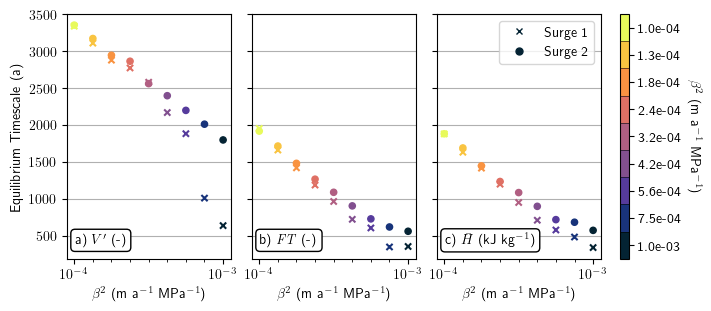

In [6]:
fig, ax = plt.subplots(1,3, sharey=True, sharex=True, figsize=(7,3),
                       constrained_layout=True)

cmap, norm, s_map, bounds = make_colorbar(-np.log(src.beta))
#overwrite the colormap with a cmocean colormap
cmap = cmocean.cm.thermal

markers = ['x', 'o']
for i in [0,1]: 
    s = ax[0].scatter(V_prime.beta,   V_prime.sel(cycle=i),   marker=markers[i], c=-np.log(src.beta),cmap=cmap, s=20.0, zorder=10)
    s = ax[1].scatter(frac_temp.beta, frac_temp.sel(cycle=i), marker=markers[i], c=-np.log(src.beta),cmap=cmap, s=20.0, zorder=10)
    s = ax[2].scatter(mean_enth.beta, mean_enth.sel(cycle=i), marker=markers[i], c=-np.log(src.beta),cmap=cmap, s=20.0, zorder=10)

pan_labels = ['a) ', 'b) ', 'c) ']
var_labels = ["$V'$ (-)", r"$\mathit{FT}$ (-)", r"$\bar{H}$ (kJ kg$^{-1}$)"]

beta = src.beta.values
test = (src.mean_surge_vel_m  / src.mean_quies_vel_m).values

for i in range(3):         
    
    ax[i].grid(which='both',axis='y',zorder=-1)
    ax[i].set_xlabel(r"$\beta^2$ (m a$^{-1}$ MPa$^{-1}$)")
    
    ax[i].text(0.05, 0.075, pan_labels[i]+ var_labels[i], 
               ha='left', va='center', transform=ax[i].transAxes, 
               bbox=dict(boxstyle="round", fc='w') )
    
    ###########################################
    # https://stackoverflow.com/a/44079725
    ###########################################
    ax[i].set_xscale('log')
    x_major = ticker.LogLocator(base = 10.0, numticks = 3)
    ax[i].xaxis.set_major_locator(x_major)
    
    x_minor = ticker.LogLocator(base=10.0, subs=np.logspace(-1,0,9)[1:-1], numticks=16)
    ax[i].xaxis.set_minor_locator(x_minor)
    ax[i].xaxis.set_minor_formatter(ticker.NullFormatter())
    
#     ax2 = ax[i].secondary_xaxis('top', functions=(backwards, forwards))
#     # ax2.set_xscale('linear')
    
#     # Get ticks from ax1 (wavelengths)
#     wl_ticks = ax[i].get_xticks()

#     # Based on the ticks from ax1 (wavelengths), calculate the corresponding
#     # energies in eV
#     E_ticks = backwards(np.logspace(-3,-4,9))

#     # Set the ticks for ax2 (Energy)
#     ax2.set_xticks(E_ticks)

#     # Allow for two decimal places on ax2 (Energy)
#     ax2.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))


legend_elements = [Line2D([],[], marker='x', label='Surge 1', linestyle='None',
                          color=cmap(0), markersize=5),
                   Line2D([0], [0], marker='o', label='Surge 2',linestyle='None',
                          color=cmap(0), markersize=5)]

ax[i].legend(handles=legend_elements)

s_map = cm.ScalarMappable(norm=norm, cmap=cmap,)
s_map.set_array(-np.log(src.beta))

cbar = fig.colorbar(s_map, 
                    ax=ax, 
                    norm=norm, 
                    aspect=30,
                    pad=0.025,
                    spacing='proportional',
                    ticks=-np.log(src.beta), 
                    boundaries=bounds,
                    drawedges=True,
                    )

cbar.set_ticklabels(map(lambda x: f'{x:1.1e}', src.beta))
cbar.set_label(r"$\beta^2$ (m a$^{-1}$ MPa$^{-1}$)", rotation=270, labelpad=15)

ax[0].set_ylabel('Equilibrium Timescale (a)')

fig.savefig('../figs/surge2steady_timescales.pdf')


In [7]:
ft_mu = frac_temp.mean()
Vp_mu = V_prime.mean()

print('-'*50)
print(f'Avg. dynamic recovery timescale: {Vp_mu:.1f} (a)')
print(f'Avg. thermo  recovery timescale: {ft_mu:.1f} (a)')
print('-'*50)
print(f'Ratio of avg. timescales:        {Vp_mu/ft_mu:.3f}')
print('-'*50)

--------------------------------------------------
Avg. dynamic recovery timescale: 2425.5 (a)
Avg. thermo  recovery timescale: 1083.5 (a)
--------------------------------------------------
Ratio of avg. timescales:        2.239
--------------------------------------------------


In [171]:
from matplotlib.transforms import (
    Bbox, TransformedBbox, blended_transform_factory)
from mpl_toolkits.axes_grid1.inset_locator import (
    BboxPatch, BboxConnector, BboxConnectorPatch)

# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/axes_zoom_effect.html#sphx-glr-gallery-subplots-axes-and-figures-axes-zoom-effect-py
def connect_bbox(bbox1, bbox2,
                 loc1a, loc2a, loc1b, loc2b,
                 prop_lines, prop_patches=None):
    if prop_patches is None:
        prop_patches = {
            **prop_lines,
            "alpha": prop_lines.get("alpha", 1) * 0.2,
            "clip_on": False,
        }

    c1 = BboxConnector(
        bbox1, bbox2, loc1=loc1a, loc2=loc2a, clip_on=False, **prop_lines)
    c2 = BboxConnector(
        bbox1, bbox2, loc1=loc1b, loc2=loc2b, clip_on=False, **prop_lines)

    bbox_patch1 = BboxPatch(bbox1, **prop_patches)
    bbox_patch2 = BboxPatch(bbox2, **prop_patches)

    p = BboxConnectorPatch(bbox1, bbox2,
                           loc1a=loc1a, loc2a=loc2a, loc1b=loc1b, loc2b=loc2b,
                           clip_on=False,
                           **prop_patches)

    return c1, c2, bbox_patch1, bbox_patch2, p

    
def zoom_effect02(ax1, ax2, **kwargs):
    """
    ax1 : the main axes
    ax1 : the zoomed axes

    Similar to zoom_effect01.  The xmin & xmax will be taken from the
    ax1.viewLim.
    """

    tt = ax1.transScale + (ax1.transLimits + ax2.transAxes)
    trans = blended_transform_factory(tt ,ax2.transData)

    mybbox1 = ax1.bbox
    mybbox2 = TransformedBbox(ax1.viewLim, trans)

    prop_patches = {**kwargs, "ec": "none", "alpha": 0.2}

    c1, c2, bbox_patch1, bbox_patch2, p = connect_bbox(
        mybbox1, mybbox2,
        loc1a=3, loc2a=4, loc1b=2, loc2b=1,
        prop_lines=kwargs, prop_patches=prop_patches)

    ax1.add_patch(bbox_patch1)
    ax2.add_patch(bbox_patch2)
    ax2.add_patch(c1)
    ax2.add_patch(c2)
    ax2.add_patch(p)

    return c1, c2, bbox_patch1, bbox_patch2, p

(54.0, 56.0)

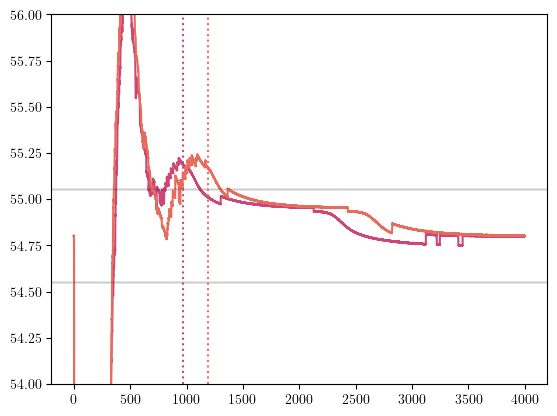

In [187]:
var = 'percent_temperate'
sub = src.sel(t=slices[1])

def redimensionalize(val, ds): 
    return val * (ds.max() - ds.min()) + ds.min()

cmap, norm, s_map, bounds = make_colorbar(np.arange(9))

for beta in range(4,6):
    n = normalize(sub[var]).isel(beta=beta,t=-1)
    m = redimensionalize(n - n * 0.01, sub[var])
    p = redimensionalize(n + n * 0.01, sub[var])
 
    color = cmap(norm(beta))
    
    plt.plot(sub.t - sub.t.isel(t=0), sub[var].isel(beta=beta), color=color)

    plt.axhline(m,alpha=0.1, color='k')
    plt.axhline(p,alpha=0.1, color='k')

    plt.axvline(frac_temp.isel(beta=beta,cycle=0), color=color, ls=":")
    
# plt.ylim(133.2, 133.4)
plt.ylim(54, 56)
# plt.ylim(0.98, 1.0)

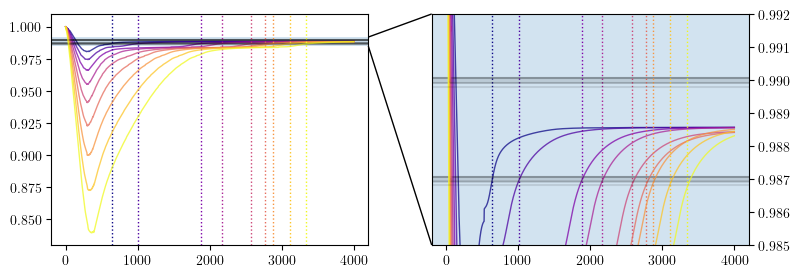

In [173]:
axs = plt.figure(figsize=(9,3)).subplot_mosaic([
    ["main", "zoom1"]])

axs["main"].set(ylim=(0.83, 1.01))
axs["zoom1"].set(ylim=(0.985, 0.992))

zoom_effect02(axs["zoom1"], axs["main"])


for beta in range(0,9):
    n = normalize(sub[var]).isel(beta=beta,t=-1)
    m = redimensionalize(n - n * 0.01, sub[var])
    p = redimensionalize(n + n * 0.01, sub[var])
    

    color = cmap(norm(beta))

    for axis in ["main", "zoom1"]: 

        axs[axis].plot(sub.t, sub[var].isel(beta=beta), color=color, lw=1.0, alpha=0.75)

        axs[axis].axhline(m,alpha=0.1, color='k')
        axs[axis].axhline(p,alpha=0.1, color='k')

        axs[axis].axvline(V_prime.isel(beta=beta,cycle=0), color=color, ls=":", lw=1.0)
        
axs["zoom1"].yaxis.tick_right()

In [174]:
axs["main"].viewLim

Bbox([[-199.84500000000003, 0.83], [4198.945, 1.01]])

In [175]:
da = norm(src.relative_volume).sel(t=slice(0.1,3999, 1))

for beta in src.beta:
    t_eq = find_equilibrium_timescale(da.sel(beta=beta), threshold=0.01)
    # print(float(t_eq))
    plt.plot(da.t, da.sel(beta=beta))
    
    plt.axvline(t_eq)
# H_f = normed.sel(t=3900,method='nearest').mean()

# plt.axhspan(H_f-0.01, H_f+0.01, alpha=0.2)

# plt.ylim(0.8, 1.0)

AttributeError: 'MaskedArray' object has no attribute 'sel'

In [ ]:
slice(0.1,3999, 1)

In [176]:
normed = norm(src.mean_enthalpy).sel(t=slice(0.1,3999, 1))


for beta in src.beta:
    
    x = normed.sel(beta=beta).compute()

    # steady-state threshold 
    thresh = 0.01

    # flip the time axis to it's decending, (i.e. work from S.S. backwards)
    x = x.sortby('t', ascending=False)
    
    v_f = x.sel(t=3999,method='nearest')
    # mask of nans where convergence threshold is not met
    mask = np.abs(x-v_f).where(lambda x: x < 0.02)
    # timesteps where convergence threshold is met
    t_mask = xr.where(~mask.isnull(), mask.t, np.nan)
    # take the difference along the valid timesteps
    # round to 6 decimal palces prevent roundoff errros
    z = np.round(t_mask.diff('t'),6)
    # find the ~first~ timestep (of the decedning time axis) where the convergence 
    # threshold is not met
    t_eq = z.where(z!=-0.1, drop=True).isel(t=0).t

    print(float(t_eq))
    plt.plot(x.t, x)
    
    plt.axvline(t_eq)
    
plt.axhspan(v_f-0.02, v_f+0.02, alpha=0.2)

plt.ylim(0.8, 1.0)

AttributeError: 'MaskedArray' object has no attribute 'sel'

In [ ]:
# da = xr.DataArray(np.arange(8).reshape(2, 4), dims=("a", "b"))
# rolling = da.rolling(b=3)
# rolling.construct("window_dim")
# src = test.relative_volume.isel(t=slice(0,40_000)).rolling(t=1000,min_periods=1).mean()
src = test.percent_temperate.interp(t=np.linspace(0,4000,40001)).rolling(t=1000,min_periods=1).mean()
src = src.interp(t=np.linspace(0,4000,4001))
src = src.compute().isel(t=slice(1,None))

# src = (src - src.min()) / (src.max() - src.min())
# target = src.isel(t=-1)
# rolling = src.compute().rolling(t=100, min_periods=1)

In [ ]:
dim = 'window_dim'
x = rolling.construct(dim) 

x_bar = x.mean(dim, skipna=False) #.sum('window_dim', skipna=False)
n = x.count('window_dim')
rmse = ((x_bar - target)/target)

In [ ]:
src[1:10].values - src[0:9].values

In [ ]:
for i, beta in enumerate(np.logspace(-6, -8, 9)**0.5):
    
    color = cmap(norm(beta**2))
        
    test = amalgamate(src_fp, beta=beta)
    # down sample to annual timeseries to constant dt=0.1
    test = test.interp(t=np.linspace(0,4000,40001)).rolling(t=1000,min_periods=1).mean()
    test = test.interp(t=np.linspace(0,4000,4001))
    
    src = test['percent_temperate'].compute().isel(t=slice(1,None))

    # src = (src - src.min()) / (src.max() - src.min())

    delta = 100*np.abs(src[1:].values - src[:-1].values) / ((src[1:].values + src[:-1].values)/2)

    # plt.plot(src.isel(t=slice(1,None)).t, delta)
    plt.plot(src.t, src)
    
    
plt.axhline(src.isel(t=-1)-1)
plt.axhline(src.isel(t=-1)+1)

# plt.yscale('log')

In [ ]:
# plt.plot(src.t, src)
# 
delta = 100 * np.abs(src[1:].values - src[:-1].values) / ((src[1:].values + src[:-1].values)/2)

plt.plot(src.isel(t=slice(1,None)).t, delta)

# plt.plot(src.isel(t=slice(10,None)).t, src.isel(t=slice(10,None)))
# plt.plot(src.isel(t=slice(0,-1)).t, src.isel(t=slice(0,-1)))

plt.axhline(0.01)
# plt.axhline(-0.05)

plt.yscale('log')

In [ ]:
# src = test.relative_volume.isel(t=slice(0,40_000))
# src = test.percent_temperate.isel(t=slice(0,40_000))
src = test.percent_temperate.interp(t=np.linspace(0,4000,40001)).rolling(t=10,min_periods=1).mean()
src = src.interp(t=np.linspace(0,4000,4001))

# plt.plot(test.t, test.percent_temperate)
# plt.plot(src.t, src)

plt.plot(src.t, src)



# plt.plot(src.t, np.abs(src - src.isel(t=1)))
# plt.plot(src.t, (src - src.isel(t=-1)) / src.isel(t=-1))
# plt.plot(src.t, (src.isel(t=-1) - src) /  src )


# diff = src.diff('t')
# plt.plot(diff.t, diff)


# plt.yscale('log')

# t_f = src.isel(t=-1).values
# plt.axhline(0.01)
# plt.axhline(-0.01)


# plt.xlim(3100, 3200)

In [ ]:
src.isel(t=1).values

In [ ]:
end_idx = -1
min_idx = src.argmin().values

t_0 = src.t.isel(t=min_idx).values
t_f   = src.t.isel(t=end_idx).values
N_end = src.isel(t=end_idx).values
N_min = src.isel(t=min_idx).values


In [ ]:
t_0 = src.t.isel(t=min_idx).values
t_f = src.t.isel(t=end_idx).values

t_vec = np.linspace(t_0, t_f, 1000)

In [ ]:
M = N_end
y0 = N_min

# Make our function to be fit
def func(t, λ):
    ''' Our function to be fit'''
    return (y0*M)/(y0+(M-y0)*np.exp(-λ*M*t))

# p0 = [-0.02, 0.003, 0.05, 2, 1.0]
# p0 = [-25, 0.003, 0.05, 2, 55.0]


subset = src.isel(t=slice(min_idx, end_idx))

# Fit the curve with reasonable inital guesses
popt, pcov = optimize.curve_fit(func, subset.t-t_0, subset.values, p0=[1/575])

In [ ]:
plt.plot(src.t, src)
plt.plot(subset.t, subset)
# plt.plot(t_vec, func(t_vec-t_0, 1/575))
# plt.plot(t_vec, func(t_vec-t_0, *popt))

plt.axhline(t_f * 0.99)

In [ ]:
t_f = subset.isel(t=-1).values


In [ ]:
t_f * 0.99

In [ ]:
# Make our function to be fit
def func(t, A, λ, ω, ϕ, C):
    ''' Our function to be fit'''
    return C + A * np.exp(-λ * t) * np.cos((ω)*t - ϕ)

p0 = [-0.02, 0.003, 0.05, 2, 1.0]
# p0 = [-25, 0.003, 0.05, 2, 55.0]

# Fit the curve with reasonable inital guesses
popt, pcov = optimize.curve_fit(func, src.t, src.values, p0=p0)

t = np.linspace(0,4000, 4001)

In [ ]:
A, λ, ω, ϕ, C = popt

In [ ]:
1/z

In [ ]:
print(f'time constant: {1/λ:.1f}')
print(f'Damping ratio: {λ/np.sqrt(λ**2 +ω**2):.1f}')


In [ ]:
plt.plot(src.t, src)

t_prime = np.linspace(0,4000, 4051)


plt.plot(t_prime, func(t_prime, *popt))

# plt.plot(t_prime, popt[4] + popt[0] * np.exp(-popt[1] * t_prime) * np.cos((popt[2])*t_prime - popt[3]))

In [ ]:
t

In [ ]:
from thermal.plotting import enthalpy_pcolormesh

fig, ax, cbar = enthalpy_pcolormesh(test, 8079)

ax.plot(test.X[0,::-1]/1e3, 
        test.Z.isel(t=0, coord_2=-1))


ax.axhline(2275)


# ax2 = ax.twinx()
# ax2.plot(test.X[0,::-1]/1e3, test.q_lat.isel(t=20).sum('coord_2'))
# ax2.plot(test.X[0,::-1]/1e3, test.q_lat.isel(t=-10).sum('coord_2'))

In [ ]:
2**30

In [ ]:
fig, ax = plt.subplots()

im = ax.scatter(test['X'][:,::-1], 
                   test['Z'].isel(t=550), 
                   c=test.q_lat.isel(t=550),
                   s=1.0
                   # vmax=0.5,
               )

ax2 = ax.twinx()
ax2.plot(test['X'][0,::-1],
        test.runoff_frac.isel(coord_2=-1,t=150))

ax.axhline(2275)
ax.axvline(3500)


fig.colorbar(im)

In [ ]:
from thermal.elements import calc_element_area

In [ ]:
calc_element_area(src)